In [1]:
import os
import cv2
import pycolmap
from hloc.utils import viz_3d
import numpy as np
import pixtrack.utils.pose_utils as pose_utils
from pixloc.utils.colmap import Camera as ColCamera
from pixloc.pixlib.geometry import Camera as PixCamera, Pose
import matplotlib.pyplot as plt
from pixtrack.utils.ingp_utils import load_nerf2sfm, initialize_ingp, sfm_to_nerf_pose, nerf_to_sfm_pose
from pixtrack.visualization.run_vis_on_poses import get_nerf_image
from scipy.spatial.transform import Rotation as R

In [2]:
from pixtrack.utils.ingp_utils import get_nerf_aabb_from_sfm

In [3]:
import math
def get_nerf_depth_image(testbed, nerf_pose, camera):
    spp = 8
    width, height = camera.size
    width = int(width)
    height = int(height)
    fl_x = float(camera.f[0])
    angle_x = math.atan(width / (fl_x * 2)) * 2

    testbed.fov = angle_x * 180 / np.pi
    testbed.set_nerf_camera_matrix(nerf_pose[:3, :])
    testbed.render_mode = testbed.render_mode.Depth

    nerf_img = testbed.render(width, height, spp, True)
    #nerf_img = nerf_img[:, :, :3] * 255.
    #nerf_img = nerf_img.astype(np.uint8)
    testbed.render_mode = testbed.render_mode.Shade
    return nerf_img

def get_nerf_image(testbed, nerf_pose, camera):
    spp = 8
    width, height = camera.size
    width = int(width)
    height = int(height)
    fl_x = float(camera.f[0])
    angle_x = math.atan(width / (fl_x * 2)) * 2

    testbed.fov = angle_x * 180 / np.pi
    testbed.set_nerf_camera_matrix(nerf_pose[:3, :])

    nerf_img = testbed.render(width, height, spp, True)
    nerf_img = nerf_img[:, :, :3] * 255.
    nerf_img = nerf_img.astype(np.uint8)
    return nerf_img

In [4]:
sfm_path = '/home/wayve/saurabh/pixtrack/data/035_power_drill/pixtrack/aug_nerf_sfm/ref/'
model = pycolmap.Reconstruction(sfm_path)


nerf_path = '/home/wayve/saurabh/pixtrack/data/035_power_drill/pixtrack/instant-ngp/snapshots/weights.msgpack'
nerf2sfm_path = '/home/wayve/saurabh/pixtrack/data/035_power_drill/pixtrack/pixsfm/dataset/nerf2sfm.pkl'
nerf2sfm = load_nerf2sfm(nerf2sfm_path)
aabb = get_nerf_aabb_from_sfm(sfm_path, nerf2sfm_path)
testbed = initialize_ingp(nerf_path, aabb=aabb)#, aabb=aabb_with_table)

02:41:46 INFO     Loading network config from: /home/wayve/saurabh/pixtrack/data/035_power_drill/pixtrack/instant-ngp/snapshots/weights.msgpack
02:41:46 INFO     GridEncoding:  Nmin=16 b=1.51572 F=2 T=2^19 L=16
02:41:46 INFO     Density model: 3--[HashGrid]-->32--[FullyFusedMLP(neurons=64,layers=3)]-->1
02:41:46 INFO     Color model:   3--[Composite]-->16+16--[FullyFusedMLP(neurons=64,layers=4)]-->3
02:41:46 INFO       total_encoding_params=13074912 total_network_params=10240


In [5]:
from pixloc.pixlib.geometry import Camera, Pose

In [6]:
point_ids = []
points3d_in_sfm = []
for point_id in model.points3D:
    point_ids.append(point_id)
    points3d_in_sfm.append(model.points3D[point_id].xyz)

points3d_in_sfm = np.array(points3d_in_sfm)
points3d_in_sfm = np.hstack((points3d_in_sfm, np.ones((points3d_in_sfm.shape[0], 1))))

camera = model.cameras[1]
cIw = pose_utils.get_camera_in_world_from_colmap_image(model.images[90])

camera = ColCamera(
    cIw, 
    camera.model_name,
    int(camera.width),
    int(camera.height),
    camera.params
)
f, cy, cx, d  = camera.params.tolist()
camera = PixCamera.from_colmap(camera)
camera = camera.scale(1.0)


In [7]:
cIw = pose_utils.get_camera_in_world_from_colmap_image(model.images[90])
sfm_in_camera = np.linalg.inv(cIw)
nerf_pose = sfm_to_nerf_pose(nerf2sfm, cIw)
nerf_depth_img = get_nerf_depth_image(testbed, nerf_pose, camera)
nerf_rgb_img = get_nerf_image(testbed, nerf_pose, camera)

In [48]:
def mask_depth_image(nerf_depth_img: np.ndarray, mask_edge: int=500, mask_value: float = 0.03):
    rows, columns, depths = nerf_depth_img.shape
    row_corner = int(rows/2) - 500
    column_corner = int(columns/2) - 500 
    curr_depth = nerf_depth_img.copy()
    curr_depth[row_corner: row_corner + mask_edge, column_corner: column_corner + mask_edge, :3] = mask_value
    return curr_depth

In [49]:
mask_depth_image = mask_depth_image(nerf_depth_img)

In [50]:
import time

In [51]:
def get_visible_indices(
    nerf2sfm, points3d_in_sfm, sfm_in_camera, depth_image,
    min_depth_threshold=1e-2, alpha_threshold=0.5, depth_closeness_threshold=5e-3
):
    """
    
    Args:
        min_depth_threshold: minimum depth of any point. Depth lower than this is considered noise
        alpha_threshold: Threshold over the visibility of the point
        depth_closeness_threshold: The threshold to decide whether a 3d point is visible in the image using depth
    """
    points3d_in_sfm_camera_frame = np.dot(
        sfm_in_camera, points3d_in_sfm.T
    ).T[:, :-1]
    pts_in_image = camera.world2image(points3d_in_sfm_camera_frame)
    project_image_points = pts_in_image[0].cpu().numpy()
    nerf2sfm_scale = nerf2sfm["avglen"] / 3.0 
    sfm_pts_in_nerf = points3d_in_sfm_camera_frame  
    depths_at_points = depth_image[
        project_image_points[:, 1].astype(int), project_image_points[:, 0].astype(int), 0]
    alphas_at_points = depth_image[
        project_image_points[:, 1].astype(int), project_image_points[:, 0].astype(int), -1]
    depths_at_points *= nerf2sfm_scale
    visible_indices = np.where(
        (depths_at_points >= min_depth_threshold) &\
        (alphas_at_points >= alpha_threshold) & \
        np.isclose(sfm_pts_in_nerf[:, 2], depths_at_points, atol=depth_closeness_threshold)
    )[0]
    return visible_indices

In [52]:
t = time.time()
visible_indices = get_visible_indices(nerf2sfm, points3d_in_sfm, sfm_in_camera, mask_depth_image)
print(time.time() - t)
#point_ids = np.array(point_ids)[visible_indices]

0.002738475799560547


In [53]:
visible_indices.shape

(5362,)

In [54]:
pts_from_sfm_with_ids = []
for point_id in model.points3D:
    if point_id in visible_indices:
        pts_from_sfm_with_ids.append(model.points3D)


In [55]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[go.Scatter3d(
            x=points3d_in_sfm[:, 0], y=points3d_in_sfm[:, 1], z=points3d_in_sfm[:, 2],
            mode='markers', marker=dict(
            size=2,
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8)),
        go.Scatter3d(
            x=points3d_in_sfm[visible_indices, 0], y=points3d_in_sfm[visible_indices, 1], z=points3d_in_sfm[visible_indices, 2],
            mode='markers', marker=dict(
            size=2,
            colorscale='gray',   # choose a colorscale
            opacity=0.8)
        )
    ]
)
fig.update_layout(scene_aspectmode='auto')
fig.show()

In [56]:
intrisics = np.array([[f, 0, cx], [0, f, cy], [0, 0, 1]])

In [57]:
points3d_in_sfm_camera_frame = np.dot(
    sfm_in_camera, points3d_in_sfm.T
).T[:, :-1]
pts_in_image = camera.world2image(points3d_in_sfm_camera_frame)[0].cpu().numpy()
visible_image_pts = pts_in_image[visible_indices]

In [58]:
nerf_rgb_img_c = nerf_rgb_img.copy()
for pt in visible_image_pts:
    nerf_rgb_img_c = cv2.circle(
        nerf_rgb_img_c, center=(int(pt[0]),int(pt[1])), radius=1, color=(0, 255, 0), thickness=-1)

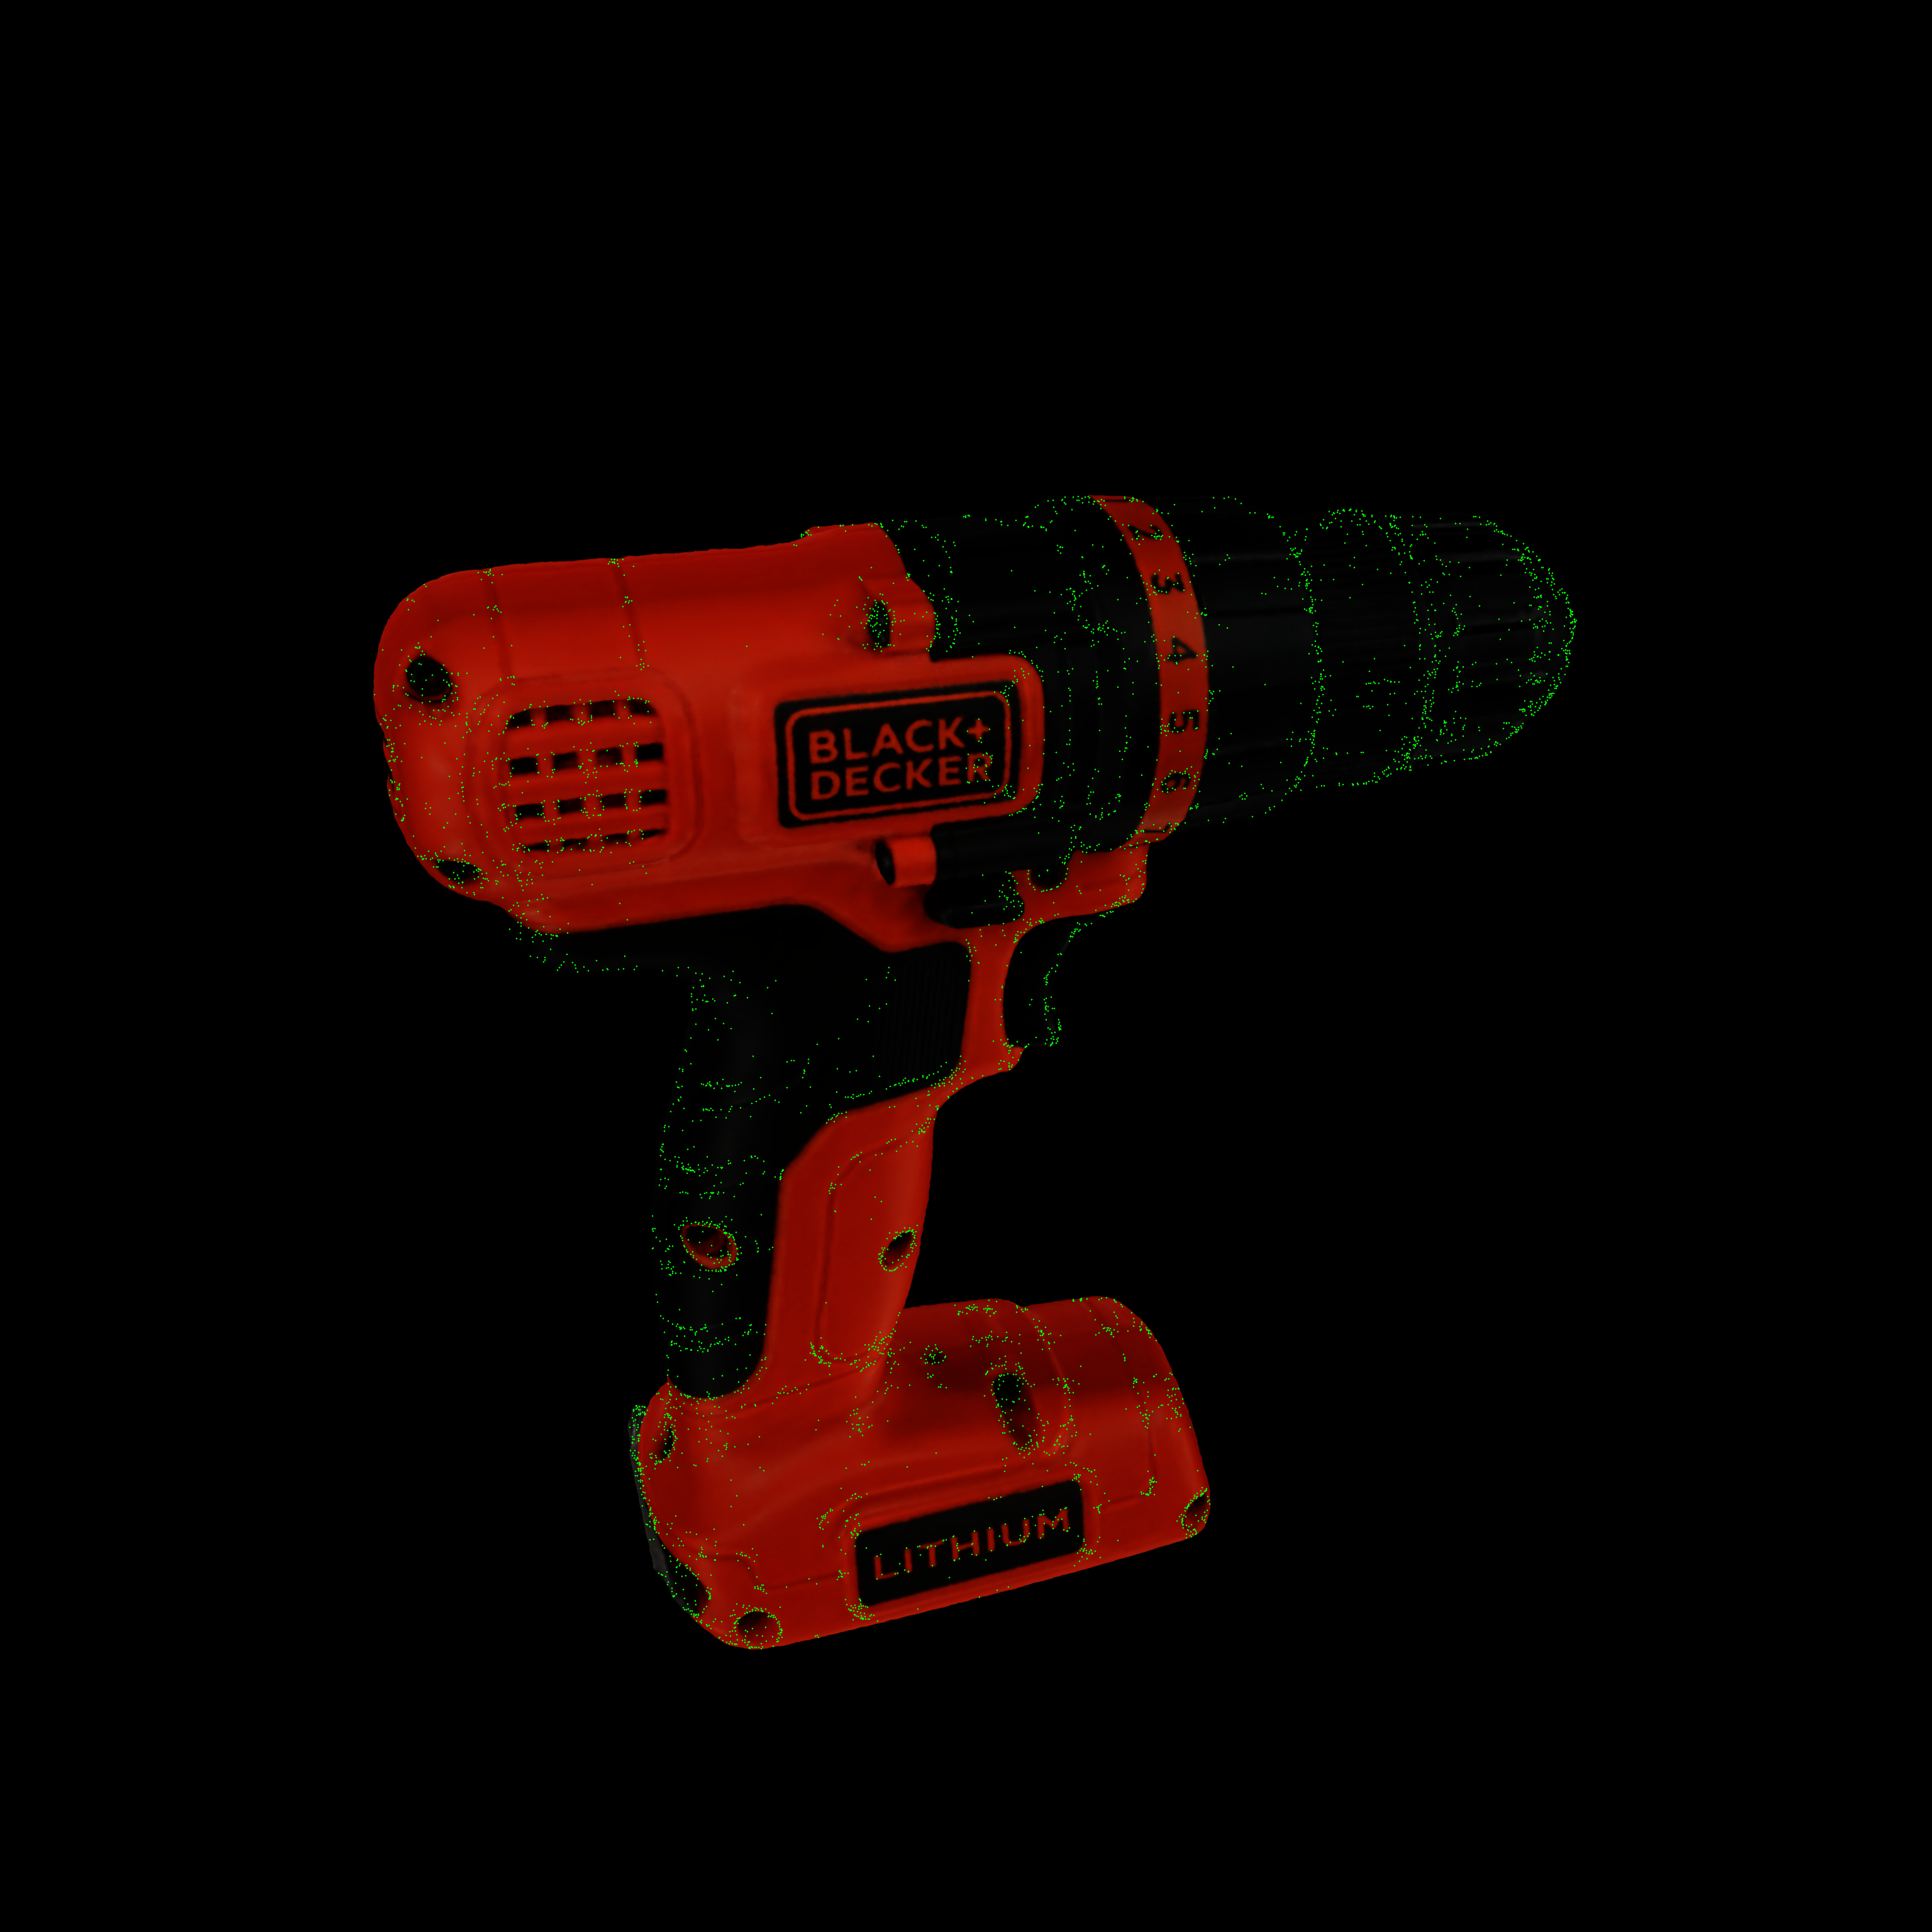

In [59]:
from PIL import Image
Image.fromarray(nerf_rgb_img_c)

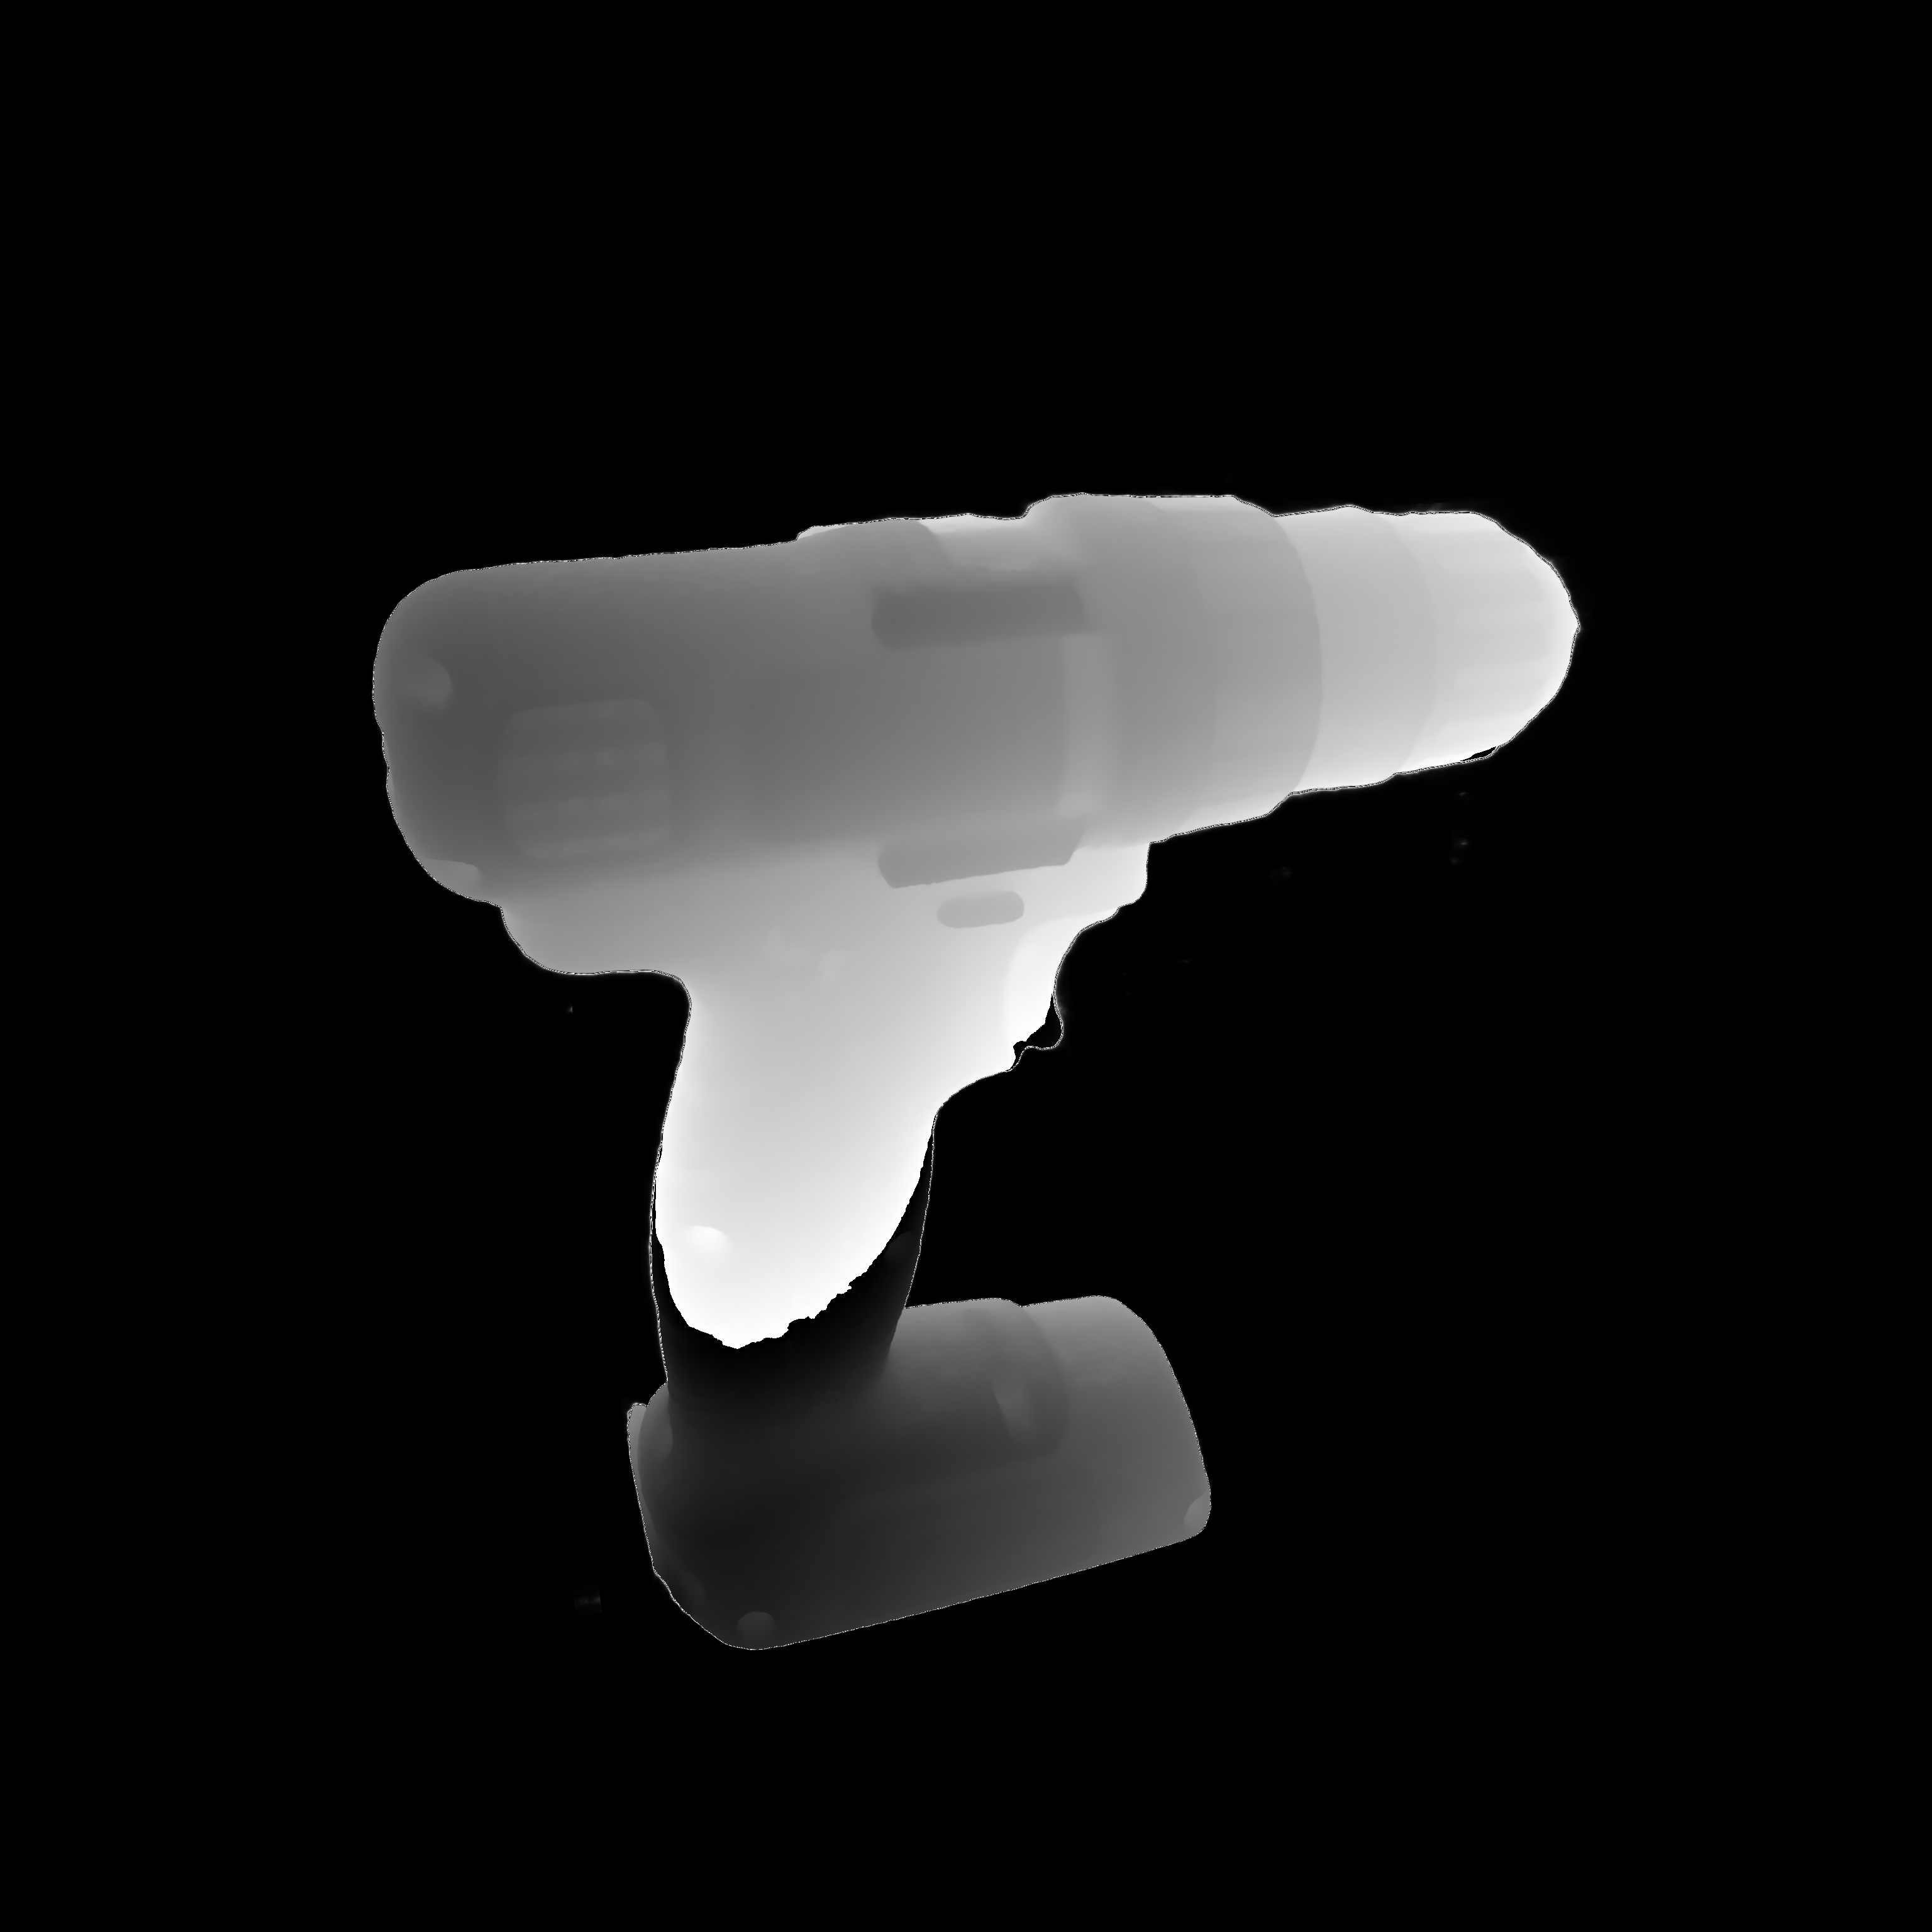

In [61]:
from PIL import Image
Image.fromarray((nerf_depth_img[:, :, 0]*255).astype(np.uint8))